## <font color = "#ef4155"> **Partie 3 : Classification supervisée à partir des images**


L'ensemble du travail effectué précédemment à démontré qu'il était difficile de regrouper automatiquement les produits par catégorie. Néanmoins, je souhaite mettre en place une classification supervisée à partir des images. J'utiliserais 4 approches :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée : ce modèle servira de basse pour comparer les autres modèles ;
* Une approche par data generator, permettant facilement la data augmentation ;
* Une approche avec Tensorflow par DataSet, sans data augmentation ;
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle.

**Protocole :**
<a id="0"></a> <br>
1. [Importation des librairies et données](#1).
2. [Création des labels et encodage](#2).
3. [Création des modèle de classification :](#3)
    * a) [Approche préparation initiale des images](#4)
    * b) [Approche ImageDatagenerator avec data augmentation](#5)
    * c) [Approche nouvelle par Dataset sans data augmentation](#6)
    * d) [Approche nouvelle par Dataset avec data augmentation intégrée au modèle](#7)
4. [Comparaison des résultats](#8)

### <font color = "#ef4155"> <a id="1"></a> **1. Import des bibliothèques et données**

#### <font color = "blue"> **Importation des librairies**

In [1]:
# Librairies générales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import os

# Librairies spécifiques à la manipulation de données
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics

# Librairies spécifiques à TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout,
                                     Rescaling, RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import (load_img, img_to_array, ImageDataGenerator)
from tensorflow.keras.utils import to_categorical

# Importation d'outils externes
from tqdm import tqdm

# Importations spécifiques à la visualisation
from plot_keras_history import show_history, plot_history

#### <font color = "blue"> **Chargement des données**

In [2]:
# Chemin vers le répertoire des images
path = "./Images/"

# Liste des noms de fichiers d'images
list_photos = [file for file in os.listdir(path)]

# Affichage du nombre total de photos
print("Nombre total de photos :", len(list_photos))

# Lecture du fichier CSV dans un DataFrame
df = pd.read_csv("./flipkart_com-ecommerce_sample_1050.csv")

# Extraction des colonnes 'image' et 'product_category_tree' du DataFrame
data = df[['image', 'product_category_tree']]

Nombre total de photos : 1052


### <font color = "#ef4155"> <a id="2"></a> **2. Création des labels et encodage**

#### <font color = "blue"> **Création des étiquettes**

In [3]:
# Définition de la fonction de récupération des catégories
def recup_cat(liste_cat):
    
    liste = []
    l_cat = []
    
    # Parcours de chaque catégorie dans la liste
    for category in liste_cat:
        # Extraction de la catégorie principale
        category = category.split(">>")[0]
        
        # Suppression des caractères indésirables
        category = category.replace('"', '').replace("'", "").replace('[', '')
        category = category[:-1]
        
        # Ajout de la catégorie à la liste
        liste.append(category)
        
        # Vérification et ajout de la catégorie à la liste des catégories uniques
        if category not in l_cat:
            l_cat.append(category)
    
    # Renvoi des listes de catégories
    return liste, l_cat

# Appel de la fonction pour récupérer les catégories
categories, l_cat = recup_cat(data['product_category_tree'])

In [4]:
# Assigner les catégories à une colonne du DataFrame en utilisant .loc
data.loc[:, 'label_name'] = categories

# Sélectionner les colonnes 'image' et 'label_name' à l'aide de .loc
data = data.loc[:, ['image', 'label_name']]

# Visualiser les données
data

C:\Users\alain\AppData\Local\Temp\ipykernel_15336\1766422538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'label_name'] = categories


,image,label_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


#### <font color = "blue"> **Encodage des labels**

In [5]:
# Création de l'instance de la classe LabelEncoder
le = preprocessing.LabelEncoder()

# Encode les labels
data["label"] = le.fit_transform(data["label_name"])

# Visualisation des données
data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


### <font color = "#ef4155"> <a id="3"> </a> **3. Création des modèles de classification**

Création d'un modèle de deep learning basé sur l'architecture VGG16, pour la classification d'images.

In [6]:
def create_model_fct():
    # Charger le modèle VGG16 pré-entraîné avec les couches supérieures exclues et spécifier la taille d'entrée
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Geler les poids des couches du modèle VGG16 pour éviter de les ré-entraîner
    for layer in model0.layers:
        layer.trainable = False
    
    # Définir l'entrée du modèle et obtenir la sortie de la dernière couche du modèle VGG16
    x = model0.output
    
    # Ajouter une couche de Global Average Pooling pour réduire les dimensions spatiales
    x = GlobalAveragePooling2D()(x)
    
    # Ajouter une couche Dense avec 256 neurones et une fonction d'activation ReLU
    x = Dense(256, activation='relu')(x)
    
    # Ajouter une couche Dropout pour régulariser le modèle et réduire le sur-apprentissage
    x = Dropout(0.5)(x)
    
    # Ajouter une couche Dense de sortie avec 7 neurones et une fonction d'activation softmax pour la classification multi-classe
    predictions = Dense(7, activation='softmax')(x)
    
    # Créer le modèle final en spécifiant les entrées et les sorties
    model = Model(inputs=model0.input, outputs=predictions)
    
    # Compiler le modèle en spécifiant la fonction de perte, l'optimiseur et les métriques
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    
    # Afficher un résumé du modèle pour obtenir un aperçu de ses couches et de ses paramètres
    print(model.summary())
    
    # Renvoyer le modèle compilé
    return model

### <font color = "green"> <a id="4"> </a> **a) Approche préparation initiale des images**

In [7]:
#  Création des données d'entrainement et de test
data_train, data_test = train_test_split(data, stratify=data['label'], test_size=0.2, random_state=0)

# Taille des données d'entrainement et de test
print('Taille des données d\'entrainement :', data_train.shape)
print('Taille des données de test :', data_test.shape)

Taille des données d'entrainement : (840, 3)
Taille des données de test : (210, 3)


_**Prétraitement des images pour les rendre compatibles avec le modèle VGG16.**_

In [8]:
def image_prep_fct(data):
    # Liste pour stocker les images préparées
    prepared_images = []
    
    # Parcourir chaque chemin d'image dans la colonne 'image' du DataFrame
    for image_file in data['image']:
        # Combiner le chemin du répertoire avec le nom du fichier d'image
        image_file = path + image_file
        
        # Charger l'image et la redimensionner à la taille cible (224x224)
        img = load_img(image_file, target_size=(224, 224))
        
        # Convertir l'image en un tableau numpy
        img = img_to_array(img)
        
        # Remodeler l'array pour avoir les dimensions (largeur, hauteur, canaux)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        
        # Prétraiter l'image en fonction des spécifications du modèle VGG16
        img = preprocess_input(img)
        
        # Ajouter l'image préparée à la liste des images préparées
        prepared_images.append(img)
    
    # Convertir la liste d'images préparées en un tableau numpy
    prepared_images_np = np.array(prepared_images)
    
    # Renvoyer le tableau d'images préparées
    return prepared_images_np

# Appel de la fonction pour préparer les images d'entraînement
images_np = image_prep_fct(data_train)
print(images_np.shape)

# Appel de la fonction pour préparer les images de test
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

c:\Users\alain\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


_**Préparation des données d'images et les étiquettes pour l'entraînement et les tests**_ <br> A cet effet, je vais définir deux variables "X" et "y"
* "X" contiendra les images d'entraînement
* "y" contiendra les étiquettes d'entraînement

In [9]:
# Attribution des données des images préparées pour l'entraînement à la variable X
X = images_np

# Encodage des étiquettes d'entraînement et attribution à la variable y
y = to_categorical(data_train['label'])

# Attribution des données des images préparées pour les tests à la variable X_test
X_test = images_np_test

# Encodage des étiquettes de test en utilisant et attribution à la variable y_test
y_test = to_categorical(data_test['label'])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [11]:
# Création du modèle
model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

_**Implémentation :**_

Les données sont séparées en deux sous-ensembles : train et test. L’apprentissage se fait par itération avec le corpus train. Chaque itération est appelée une époque (epoch) ou
un épisode. L’évaluation (validation) est effectuée avec le second corpus, test. Les courbes de la précision (accuracy) et de la fonction de perte (loss) permettront de
suivre la progression de l’apprentissage.

_**Apprentissage**_

In [12]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1 = time.time()

history1 = model1.fit(X_train, y_train, epochs=20, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

duration1 =time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 4.3984 - accuracy: 0.4857
Epoch 1: val_loss improved from inf to 1.64176, saving model to .\model1_best_weights.h5


c:\Users\alain\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 189s 9s/step - loss: 4.3984 - accuracy: 0.4857 - val_loss: 1.6418 - val_accuracy: 0.7286
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.7143
Epoch 2: val_loss improved from 1.64176 to 1.33628, saving model to .\model1_best_weights.h5
20/20 [==============================] - 172s 9s/step - loss: 1.7823 - accuracy: 0.7143 - val_loss: 1.3363 - val_accuracy: 0.7810
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.7730
Epoch 3: val_loss improved from 1.33628 to 0.95146, saving model to .\model1_best_weights.h5
20/20 [==============================] - 168s 9s/step - loss: 1.1732 - accuracy: 0.7730 - val_loss: 0.9515 - val_accuracy: 0.8190
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.9889 - accuracy: 0.7857
Epoch 4: val_loss improved from 0.95146 to 0.89543, saving model to .\model1_best_weights.h5
20/20 [==============================] - 168s 8s/

_**Evaluation**_

In [13]:
# Évaluation des pertes et de la précision sur les données d'entraînement
loss1_train, accuracy1_train = model1.evaluate(X_train, y_train, verbose=True)

# Évaluation des pertes et de la précision sur les données de validation
loss1_val, accuracy1_val = model1.evaluate(X_val, y_val, verbose=True)

7/7 [==============================] - 40s 6s/step - loss: 0.9999 - accuracy: 0.8238


_**Analyse graphique**_

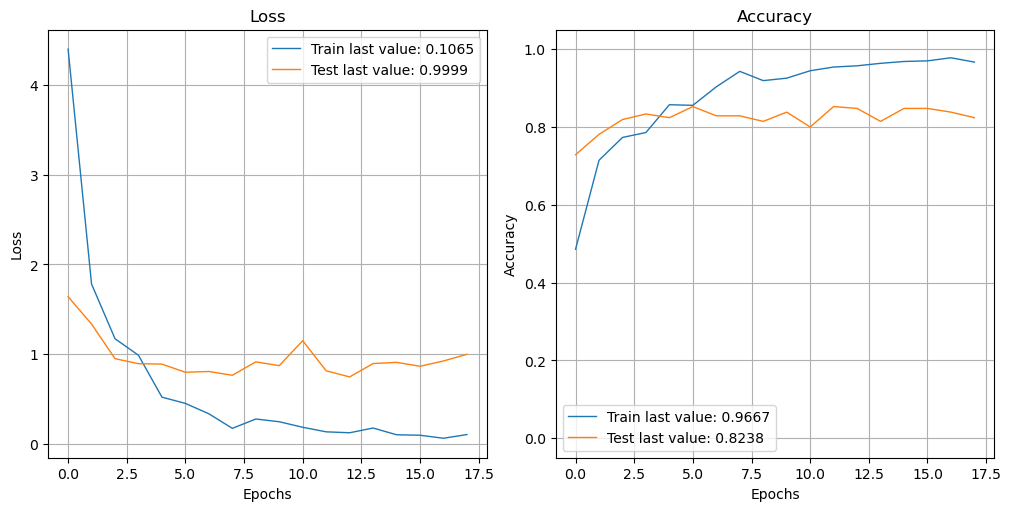

In [14]:
# Afficher les graphiques d'historique d'entraînement à partir d'un objet history (historique) donné
show_history(history1)

# Créer un graphique d'historique personnalisé et l'enregistrer sous forme d'image PNG
plot_history(history1, path="standard.png")

# Fermer le graphique pour libérer les ressources mémoire
plt.close()

Au-delà d’une certaine durée d’apprentissage, on peut observer que la précision continue de progresser avec le corpus d’apprentissage tandis qu’elle stagne ou se met à
régresser avec le corpus de test : ce qui signifie que **le modèle sur-apprend (overfitting)**. <br> Avec ce modèle, nous obtenons une **précision globale de 89,5 %**. Celle-ci peut être analysée plus finement en visualisant la **matrice de confusion**.

In [15]:
# Convertir les étiquettes valides encodées en numériques
y_val_num = np.argmax(y_val, axis=1)

# Prédire les étiquettes à partir du modèle pour les données de validation et convertir les prédictions encodées en numériques
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

7/7 [==============================] - 41s 6s/step


In [16]:
# Calcul de la matrice de confusion à partir des étiquettes réelles et prédites des données de validation
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

Rapport de classification :
               precision    recall  f1-score   support

           0       0.68      0.77      0.72        30
           1       0.88      0.70      0.78        30
           2       0.89      0.83      0.86        30
           3       0.76      0.87      0.81        30
           4       0.83      0.80      0.81        30
           5       0.80      0.93      0.86        30
           6       1.00      0.87      0.93        30

    accuracy                           0.82       210
   macro avg       0.83      0.82      0.82       210
weighted avg       0.83      0.82      0.82       210



In [17]:
class_names = ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs',
             'Home Furnishing', 'Kitchen & Dining', 'Watches']

<Axes: >

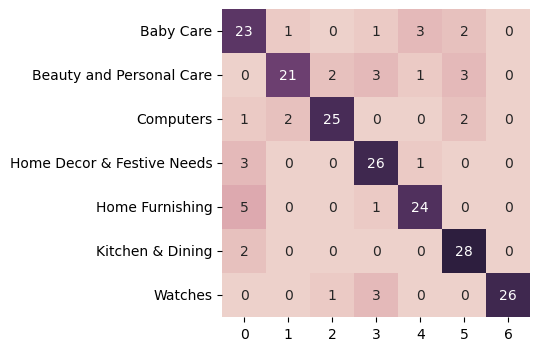

In [19]:
# Créer un DataFrame contenant les labels réels et les labels prédits
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])

# Paramètre de la figure
plt.figure(figsize = (6,4))
plt.title('Matrice de confusion', fontsize = 10, color = "#ef4155", fontweight = "bold")

# Afficher la matrice de confusion en tant que heatmap
sns.heatmap(df_cm, square=True, annot=True, annot_kws={"size": 10}, fmt='.0f', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)

La matrice de confusion montre que le modèle commet peu d'erreurs par catégorie.

_**Prédictions sur le jeu de données de test**_

In [20]:
# Évaluation du modèle sur les données de test pour calculer la perte et la précision (verbose = 1 affiche les détails)
test_loss1, test_acc1 = model1.evaluate(X_test, y_test, verbose=1)

# Affichage de la précision du modèle sur les données de test
print('\nPrécision sur les données de test :', test_acc1)

7/7 [==============================] - 35s 5s/step - loss: 1.3569 - accuracy: 0.8381

Précision sur les données de test : 0.8380952477455139


In [21]:
# Prédiction des étiquettes et stockage dans la variable "predictions1"
predictions1 = model1.predict(X_test)

7/7 [==============================] - 43s 6s/step


_Affichage des images de test, leurs classes prédites et les probabilités associées._

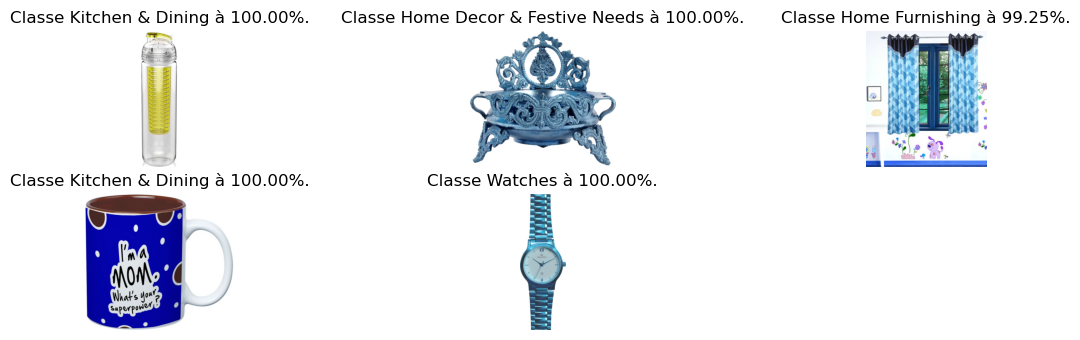

In [24]:
# Création d'une figure pour afficher les images avec une taille de 14x6 pouces
plt.figure(figsize=(14, 6))

# Boucle sur les 5 premières images
for i in range(5):
    # Création d'un sous-graphique dans une grille 3x3 
    ax = plt.subplot(3, 3, i + 1)
    
    # Chargement de l'image à partir du chemin complet
    image = cv2.imread(path + data_test.iloc[10 + i]['image'])
    
    # Affichage de l'image dans le sous-graphique
    plt.imshow(image)
    
    # Ajout d'un titre indiquant la classe prédite et la probabilité associée
    plt.title("Classe {} à {:.2f}%.".format(class_names[np.argmax(predictions1[10 + i])], 100 * np.max(predictions1[10 + i])))
    
    # Désactivation des axes du sous-graphique
    plt.axis("off")

Les résultats des prédictions sont satisfaisant avec une précision élevée. Je peux confirmer ce résultat en calculant le score de similarité ARI afin de mesurer à quel point les regroupements (clusters) des données sont similaires entre les étiquettes réelles et prédites.

In [25]:
# Création d'une liste contenant les étiquettes prédites pour chaque exemple
# Utilisation de la fonction argmax pour obtenir l'indice de la classe prédite,
# puis récupération de la classe correspondante à partir de class_names
labels_pred = [class_names[np.argmax(predictions1[i])] for i in range(len(predictions1))]

# Récupération des étiquettes réelles à partir du DataFrame data_test
labels = data_test['label_name']

# Calcul de l'Adjusted Rand Index (ARI) pour évaluer la similarité entre les étiquettes réelles et prédites
score1_ari = metrics.adjusted_rand_score(labels, labels_pred)

# Affichage du score ARI
print("Adjusted Rand Index (ARI) : ", score1_ari)


Adjusted Rand Index (ARI) :  0.6614260451528474


Le score ARI, presque égale à 0,7 montre une bonne similarité entre les valeurs réelles et prédites.

### <font color = "green"> <a id="5"> </a> **b) Approche ImageDatagenerator avec data augmentation**

Je vais créer un générateur de flux de données capable de charger et traiter les images. Ce générateur sera ensuite utilisé pour entraîner notre modèle. <br> Référence : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow

In [26]:
def data_flow_fct(data, datagen, data_type=None):
    # Crée un générateur de flux de données (DataGenerator) à partir du DataFrame 'data'    
    data_flow = datagen.flow_from_dataframe(data, directory=path,
                                             x_col='image', y_col='label_name',
                                             weight_col=None, target_size=(224, 224),
                                             classes=None, class_mode='categorical',
                                             shuffle=True, seed=42, subset=data_type)
    
    # Renvoie le générateur de flux de données créé
    return data_flow

In [27]:
# Crée un objet ImageDataGenerator pour augmenter les données d'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=20,               # Rotation aléatoire des images dans la plage de 20 degrés
    width_shift_range=0.2,           # Décalage horizontal aléatoire des images
    height_shift_range=0.2,          # Décalage vertical aléatoire des images
    horizontal_flip=True,            # Retournement horizontal aléatoire des images
    validation_split=0.25,           # Fraction des données à utiliser pour la validation
    preprocessing_function=preprocess_input)  # Fonction de prétraitement des images

# Crée un générateur de flux de données pour l'entraînement à partir des données d'entraînement
train_flow = data_flow_fct(data_train, datagen_train, data_type='training')

# Crée un générateur de flux de données pour la validation à partir des données d'entraînement
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

# Crée un objet ImageDataGenerator pour les données de test
datagen_test = ImageDataGenerator(
    validation_split=0,              # Pas de validation, car il s'agit des données de test
    preprocessing_function=preprocess_input)  # Fonction de prétraitement des images

# Crée un générateur de flux de données pour les données de test à partir des données de test
test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [28]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
temps2 = time.time()

history2 = model2.fit(train_flow, validation_data=val_flow, epochs=20, callbacks=callbacks_list, verbose=1)
duration2=time.time()-temps2

print("temps de T-SNE : ", "%15.2f" % duration2, "secondes")

Epoch 1/20
10/20 [==============>...............] - ETA: 1:03 - loss: 6.1958 - accuracy: 0.3406

c:\Users\alain\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 [==============================] - ETA: 0s - loss: 4.6720 - accuracy: 0.4333
Epoch 1: val_loss improved from inf to 1.56017, saving model to .\model2_best_weights.h5
20/20 [==============================] - 178s 9s/step - loss: 4.6720 - accuracy: 0.4333 - val_loss: 1.5602 - val_accuracy: 0.6810
Epoch 2/20


c:\Users\alain\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - ETA: 0s - loss: 1.7459 - accuracy: 0.6540
Epoch 2: val_loss improved from 1.56017 to 1.13580, saving model to .\model2_best_weights.h5
20/20 [==============================] - 175s 9s/step - loss: 1.7459 - accuracy: 0.6540 - val_loss: 1.1358 - val_accuracy: 0.7190
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.7349
Epoch 3: val_loss did not improve from 1.13580
20/20 [==============================] - 175s 9s/step - loss: 1.0816 - accuracy: 0.7349 - val_loss: 1.1527 - val_accuracy: 0.7524
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.8624 - accuracy: 0.7857
Epoch 4: val_loss improved from 1.13580 to 1.03986, saving model to .\model2_best_weights.h5
20/20 [==============================] - 175s 9s/step - loss: 0.8624 - accuracy: 0.7857 - val_loss: 1.0399 - val_accuracy: 0.7952
Epoch 5/20
20/20 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.8000
Epoch 5: val

In [30]:
loss2_train, accuracy2_train = model2.evaluate(train_flow, verbose=True)
loss2_val, accuracy2_val = model2.evaluate(val_flow, verbose=True)

7/7 [==============================] - 80s 11s/step - loss: 1.1419 - accuracy: 0.8048


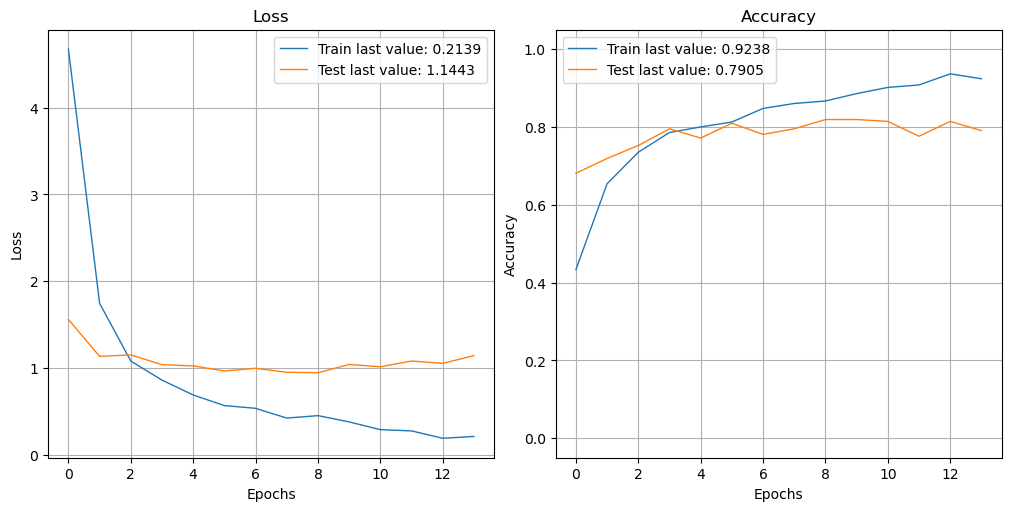

In [31]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

Ici aussi le modèle est en sur-apprentissage. 
Observons la matrice de confusion.

In [32]:
predicted_labels = []
true_labels = []
for i in range(len(val_flow)):
    images, labels = val_flow[i]
    predicted_labels_batch = model2.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

1/1 [==============================] - 8s 8s/step
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        30
           1       0.83      0.76      0.79        33
           2       0.80      0.73      0.76        33
           3       0.79      0.66      0.72        35
           4       0.59      0.83      0.69        23
           5       0.81      0.93      0.87        28
           6       0.90      1.00      0.95        28

    accuracy                           0.78       210
   macro avg       0.78      0.79      0.77       210
weighted avg       0.78      0.78      0.77       210



<Axes: >

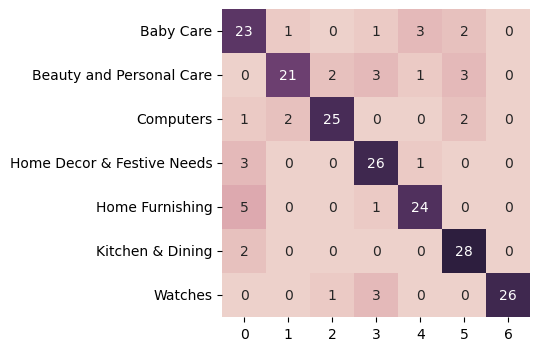

In [33]:
# Créer la matrice de confusion
confusion_mat = metrics.confusion_matrix(true_labels, predicted_labels)

df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))

# Afficher la matrice de confusion en tant que heatmap
sns.heatmap(df_cm, square=True, annot=True, annot_kws={"size": 10}, fmt='.0f', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)

La matrice de confusion confirme les bons scores : le modèle fait peu d'erreur.

_**Prédictions sur le dataset de test**_

In [34]:
predictions2 = []
true_labels = []
for i in range(len(test_flow)):
    images, labels = test_flow[i]
    predictions2_batch = model2.predict(images)
    predictions2 += list(np.argmax(predictions2_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

1/1 [==============================] - 7s 7s/step


In [35]:
score2_ari = metrics.adjusted_rand_score(true_labels, predictions2)
print("ARI : ", score2_ari)

ARI :  0.6389668349456932


In [36]:
score2_r2 = model2.evaluate(test_flow)[1]
print("r2 : ",score2_r2)

7/7 [==============================] - 47s 6s/step - loss: 1.3416 - accuracy: 0.8238
r2 :  0.8238095045089722


Avec un score ARI = 0,6, ce modèle est moins performant que le précédent.

### <font color = "green"> <a id="6"> </a> **c) Approche nouvelle par Dataset sans data augmentation**

CF https://www.tensorflow.org/tutorials/load_data/images

### Création des répertoires de classes

In [38]:
# créer les dossiers du data_train

os.mkdir('./photos_train')

import shutil

for classe in l_cat:
    # Créer le dossier de la classe
    path_classe = './photos_train/class_'+classe+'/'
    os.mkdir(path_classe)
    
    # créer une liste des images de la classe
    l_images = data_train.loc[data_train["label_name"]==classe, 'image']
    
    # Définir le chemin complet du dossier de destination
    destination_path = path_classe
    
    for image in l_images :
        # Définir le chemin complet de l'image à copier
        source_path = './Images/'+image
    
        # Copier l'image vers le dossier de destination
        shutil.copy(source_path, destination_path)

In [40]:
# créer les dossiers du data_test

os.mkdir('./photos_test')

for classe in l_cat:
    # Créer le dossier de la classe
    path_classe = './photos_test/class_'+classe+'/'
    os.mkdir(path_classe)
    
    # créer une liste des images de la classe
    l_images = data_test.loc[data_test["label_name"]==classe, 'image']
    
    # Définir le chemin complet du dossier de destination
    destination_path = path_classe
    
    for image in l_images :
        # Définir le chemin complet de l'image à copier
        source_path = './Images/'+image
    
        # Copier l'image vers le dossier de destination
        shutil.copy(source_path, destination_path)

In [41]:
def dataset_fct(path, validation_split=0, data_type=None, data=data) :
    dataset = tf.keras.utils.image_dataset_from_directory(path,image_size=(224, 224),shuffle=True, seed=42,validation_split=validation_split, subset=data_type)
    return dataset

In [42]:
chemin_train = './photos_train/'
chemin_test = './photos_test/'

dataset_train = dataset_fct(chemin_train, validation_split=0.25, data_type='training', data = data_train)
dataset_val = dataset_fct(chemin_train, validation_split=0.25, data_type='validation', data = data_train)
dataset_test = dataset_fct(chemin_test, validation_split=0, data_type=None, data = data_test)

Found 840 files belonging to 7 classes.


Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [43]:
class_names = dataset_train.class_names
class_names

['class_Baby Care',
 'class_Beauty and Personal Care',
 'class_Computers',
 'class_Home Decor & Festive Needs',
 'class_Home Furnishing',
 'class_Kitchen & Dining',
 'class_Watches']

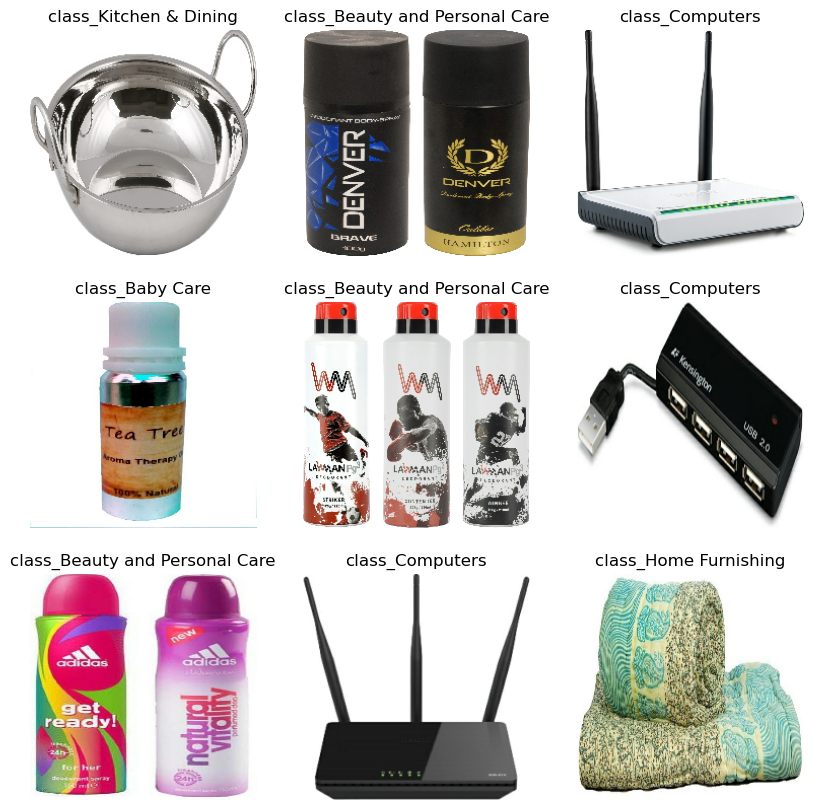

In [44]:
# Visualisation

plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Quelques exemples avec leur label pour vérifier si les images ont été placées dans le bon répertoire.

In [45]:
for image_batch, labels_batch in dataset_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


L' image_batch est un tenseur de la forme (32, 224, 224, 3) . Il s'agit d'un lot de 32 images de forme 224x224x3 (la dernière dimension fait référence aux canaux de couleur RVB). Le label_batch est un tenseur de la forme (32,) , ce sont des labels correspondants aux 32 images.

In [46]:
# Création du modèle
model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
temps3 = time.time()

history3 = model3.fit(dataset_train, validation_data=dataset_val, epochs=20, callbacks=callbacks_list, verbose=1)

duration3=time.time()-temps3
print("temps de T-SNE : ", "%15.2f" % duration3, "secondes")

Epoch 1/20


c:\Users\alain\anaconda3\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - ETA: 0s - loss: 6.6560 - accuracy: 0.4444
Epoch 1: val_loss improved from inf to 1.67928, saving model to .\model3_best_weights.h5
20/20 [==============================] - 181s 9s/step - loss: 6.6560 - accuracy: 0.4444 - val_loss: 1.6793 - val_accuracy: 0.7571


c:\Users\alain\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 2.1326 - accuracy: 0.7175 
Epoch 2: val_loss improved from 1.67928 to 1.33964, saving model to .\model3_best_weights.h5
20/20 [==============================] - 332s 17s/step - loss: 2.1326 - accuracy: 0.7175 - val_loss: 1.3396 - val_accuracy: 0.7762
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.3920 - accuracy: 0.7460 
Epoch 3: val_loss improved from 1.33964 to 1.12932, saving model to .\model3_best_weights.h5
20/20 [==============================] - 366s 18s/step - loss: 1.3920 - accuracy: 0.7460 - val_loss: 1.1293 - val_accuracy: 0.8048
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.7952 
Epoch 4: val_loss improved from 1.12932 to 1.02381, saving model to .\model3_best_weights.h5
20/20 [==============================] - 333s 17s/step - loss: 0.8956 - accuracy: 0.7952 - val_loss: 1.0238 - val_accuracy: 0.7905
Epoch 5/20
20/20 [=========================

In [49]:
loss3_train, accuracy3_train = model3.evaluate(dataset_train, verbose=True)
loss3_val, accuracy3_val = model3.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 52s 7s/step - loss: 0.8665 - accuracy: 0.8286


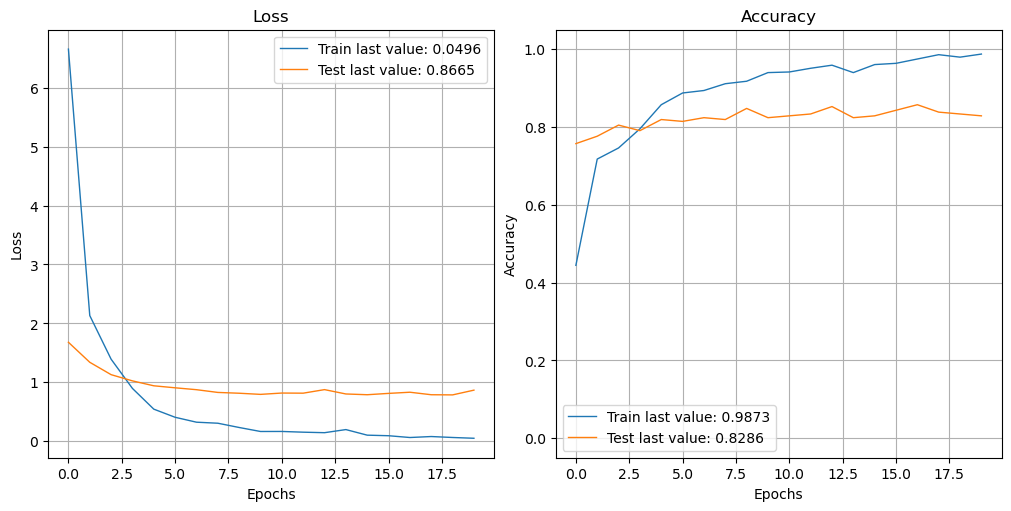

In [50]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

Les scores sont très bons mais le modèle est en overfitting.

In [51]:
predicted_labels = []
true_labels = []
for images, labels in dataset_val:
    predicted_labels_batch = model3.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(labels.numpy())
print(true_labels)
print()
print(predicted_labels)

1/1 [==============================] - 4s 4s/step
[5, 6, 4, 5, 6, 2, 3, 5, 0, 5, 0, 1, 0, 5, 2, 3, 4, 3, 3, 2, 5, 1, 4, 1, 5, 4, 5, 5, 4, 0, 6, 2, 3, 1, 3, 1, 0, 0, 4, 3, 5, 0, 5, 6, 3, 2, 2, 2, 3, 2, 3, 0, 2, 4, 6, 6, 3, 0, 0, 6, 5, 4, 5, 2, 1, 0, 2, 5, 6, 0, 4, 0, 2, 2, 5, 0, 1, 1, 1, 5, 5, 3, 2, 3, 5, 2, 1, 1, 5, 4, 5, 5, 3, 5, 6, 2, 1, 1, 4, 5, 2, 1, 0, 4, 6, 4, 0, 4, 3, 2, 4, 4, 2, 5, 1, 3, 0, 1, 4, 4, 6, 3, 1, 1, 0, 2, 3, 2, 0, 1, 5, 6, 0, 6, 0, 4, 1, 3, 4, 5, 3, 3, 2, 5, 4, 3, 5, 3, 6, 3, 5, 5, 1, 0, 0, 6, 3, 4, 6, 5, 6, 5, 6, 1, 0, 3, 4, 3, 0, 4, 6, 6, 5, 2, 4, 4, 2, 1, 6, 2, 6, 5, 0, 6, 1, 0, 1, 4, 5, 2, 3, 3, 4, 3, 6, 6, 6, 4, 6, 0, 6, 4, 6, 3, 3, 1, 5, 3, 5, 3]

[5, 6, 4, 5, 6, 2, 3, 5, 4, 5, 0, 0, 0, 2, 2, 5, 4, 3, 3, 2, 5, 1, 4, 1, 5, 4, 5, 5, 1, 0, 6, 2, 3, 1, 3, 1, 3, 0, 4, 3, 5, 0, 5, 6, 5, 2, 2, 2, 6, 2, 3, 4, 2, 4, 6, 6, 3, 0, 4, 6, 5, 4, 5, 2, 1, 0, 2, 5, 6, 0, 4, 4, 1, 2, 2, 0, 1, 3, 2, 5, 5, 5, 2, 3, 5, 2, 1, 1, 5, 4, 5, 5, 3, 5, 1, 4, 1, 1, 4, 5, 2, 1, 0, 4, 6, 4,

<Axes: >

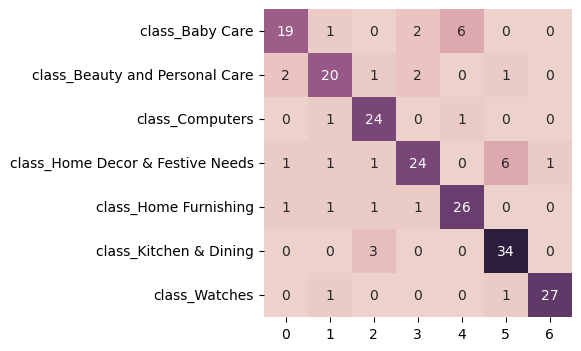

In [53]:
# Créer la matrice de confusion
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Créer le dataframe de confusion
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
# Paramètre de la figure
plt.figure(figsize = (6,4))
# Affichage de la matrice de confusion
sns.heatmap(df_cm, square=True, annot=True, annot_kws={"size": 10}, fmt='.0f', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)

Le modèle à beaucoup du mal à prédire les class "Baby Care" et "Home Decor...".

_**Prédictions sur le jeu de données de test**_

In [54]:
predictions3 = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model3.predict(images)
    predictions3 += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions3)

1/1 [==============================] - 4s 4s/step
[1, 5, 2, 1, 0, 1, 5, 5, 6, 1, 6, 3, 4, 0, 0, 4, 0, 2, 4, 4, 0, 6, 4, 2, 0, 1, 3, 4, 0, 5, 4, 2, 6, 1, 0, 4, 3, 0, 0, 2, 4, 5, 3, 0, 3, 6, 3, 5, 1, 3, 1, 4, 5, 0, 6, 1, 3, 0, 0, 0, 5, 4, 4, 4, 4, 2, 6, 4, 2, 0, 0, 2, 1, 6, 0, 3, 1, 6, 5, 6, 5, 2, 3, 0, 0, 6, 1, 2, 2, 6, 1, 3, 3, 5, 6, 4, 6, 4, 6, 4, 4, 1, 5, 2, 2, 1, 1, 1, 5, 3, 1, 2, 3, 6, 0, 5, 3, 1, 0, 6, 3, 6, 3, 5, 3, 5, 3, 6, 4, 5, 1, 1, 2, 3, 1, 4, 5, 0, 5, 3, 0, 4, 6, 1, 4, 3, 2, 1, 5, 3, 5, 5, 2, 4, 4, 4, 2, 2, 5, 1, 6, 6, 2, 6, 6, 1, 0, 3, 5, 5, 5, 3, 2, 6, 2, 0, 2, 6, 5, 1, 5, 1, 6, 1, 2, 2, 0, 4, 3, 2, 3, 0, 2, 1, 3, 0, 4, 3, 4, 4, 5, 0, 3, 2, 5, 6, 6, 2, 2, 6]

[2, 5, 2, 4, 0, 0, 5, 0, 6, 1, 6, 3, 3, 3, 0, 4, 0, 2, 4, 0, 4, 5, 4, 1, 0, 1, 3, 4, 0, 5, 4, 2, 6, 1, 0, 4, 3, 0, 4, 2, 0, 5, 3, 0, 3, 6, 3, 5, 1, 5, 4, 4, 5, 4, 6, 1, 3, 4, 0, 0, 1, 4, 4, 4, 4, 2, 6, 4, 3, 0, 0, 2, 1, 6, 0, 3, 2, 6, 5, 6, 1, 2, 3, 3, 3, 6, 1, 2, 2, 6, 1, 3, 3, 5, 6, 4, 6, 4, 6, 4, 4, 1, 5, 2, 2, 1,

In [55]:
score3_r2 = model3.evaluate(dataset_test)[1]
print("r2 : ",score3_r2)

7/7 [==============================] - 52s 7s/step - loss: 1.0712 - accuracy: 0.8143
r2 :  0.8142856955528259


In [56]:
score3_ari = metrics.adjusted_rand_score(labels_test, predictions3)
print("ARI : ", score3_ari)

ARI :  0.6271463614063778


### <font color = "green"> <a id="7"> </a> **d) Approche nouvelle par Dataset avec data augmentation intégrée au modèle**

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [57]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [58]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [59]:
# Création du modèle
model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
temps4 = time.time()

history4 = model4.fit(dataset_train, validation_data=dataset_val, epochs=35, callbacks=callbacks_list, verbose=1)

duration4=time.time()-temps4
print("temps de T-SNE : ", "%15.2f" % duration4, "secondes")

Epoch 1/35


20/20 [==============================] - ETA: 0s - loss: 1.8734 - accuracy: 0.2698
Epoch 1: val_loss improved from inf to 1.41320, saving model to .\model4_best_weights.h5
20/20 [==============================] - 226s 11s/step - loss: 1.8734 - accuracy: 0.2698 - val_loss: 1.4132 - val_accuracy: 0.6619


c:\Users\alain\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/35
20/20 [==============================] - ETA: 0s - loss: 1.4195 - accuracy: 0.5349
Epoch 2: val_loss improved from 1.41320 to 1.08924, saving model to .\model4_best_weights.h5
20/20 [==============================] - 188s 9s/step - loss: 1.4195 - accuracy: 0.5349 - val_loss: 1.0892 - val_accuracy: 0.7714
Epoch 3/35
20/20 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.6476
Epoch 3: val_loss improved from 1.08924 to 0.94455, saving model to .\model4_best_weights.h5
20/20 [==============================] - 167s 8s/step - loss: 1.1865 - accuracy: 0.6476 - val_loss: 0.9446 - val_accuracy: 0.7524
Epoch 4/35
20/20 [==============================] - ETA: 0s - loss: 1.0402 - accuracy: 0.6540
Epoch 4: val_loss improved from 0.94455 to 0.82912, saving model to .\model4_best_weights.h5
20/20 [==============================] - 197s 10s/step - loss: 1.0402 - accuracy: 0.6540 - val_loss: 0.8291 - val_accuracy: 0.8000
Epoch 5/35
20/20 [==============================

In [61]:
loss4_train, accuracy4_train = model4.evaluate(dataset_train, verbose=True)
loss4_val, accuracy4_val = model4.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 45s 6s/step - loss: 0.5658 - accuracy: 0.8286


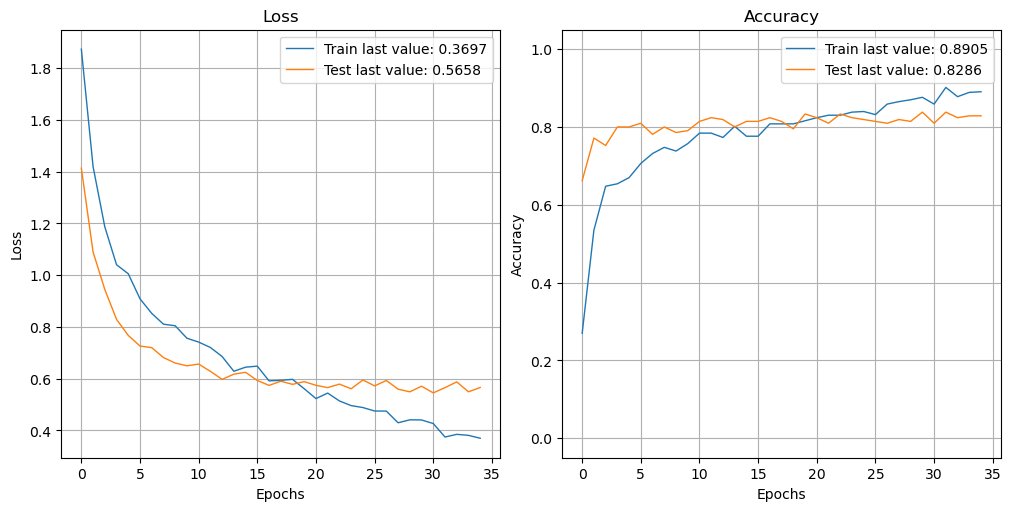

In [62]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

Contrairement aux autres approches, ce modèle arrive à généraliser : pas de sur-apprentissage. Les pertes sont équivalentes entre les données d'apprentissage et de validation.

In [63]:
predicted_labels = []
true_labels = []
for images, labels in dataset_val:
    predicted_labels_batch = model4.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(labels.numpy())
print(true_labels)
print()
print(predicted_labels)

1/1 [==============================] - 4s 4s/step
[6, 3, 2, 2, 4, 3, 6, 1, 4, 1, 1, 5, 5, 3, 5, 2, 4, 6, 5, 3, 2, 0, 0, 2, 5, 0, 4, 5, 3, 4, 2, 6, 1, 1, 5, 1, 3, 2, 5, 1, 6, 5, 5, 0, 1, 3, 5, 4, 2, 5, 6, 1, 5, 3, 0, 3, 3, 4, 5, 3, 0, 1, 2, 0, 5, 4, 4, 6, 5, 6, 6, 1, 0, 4, 0, 2, 4, 0, 6, 5, 6, 0, 1, 3, 1, 5, 2, 0, 2, 4, 2, 0, 3, 0, 2, 5, 3, 6, 4, 2, 1, 6, 4, 1, 2, 0, 6, 3, 5, 0, 1, 6, 1, 2, 3, 4, 0, 4, 3, 0, 5, 6, 5, 0, 1, 6, 4, 4, 3, 4, 3, 4, 3, 2, 3, 4, 5, 0, 5, 4, 5, 2, 5, 6, 4, 2, 1, 4, 3, 3, 4, 5, 3, 3, 4, 2, 6, 6, 2, 6, 3, 3, 4, 1, 1, 3, 3, 3, 0, 6, 1, 5, 5, 6, 0, 1, 4, 6, 3, 5, 5, 6, 2, 5, 2, 5, 3, 6, 1, 0, 5, 4, 5, 1, 5, 0, 1, 2, 4, 0, 5, 6, 0, 0, 6, 6, 3, 0, 2, 3]

[6, 3, 2, 2, 4, 3, 6, 1, 4, 1, 1, 5, 5, 3, 5, 2, 4, 6, 5, 3, 2, 4, 0, 2, 5, 4, 4, 5, 0, 4, 2, 6, 3, 1, 5, 1, 3, 2, 5, 1, 6, 5, 5, 0, 1, 3, 5, 4, 1, 5, 6, 1, 5, 3, 0, 3, 5, 4, 5, 3, 0, 1, 1, 0, 5, 4, 4, 6, 5, 6, 6, 2, 0, 4, 4, 2, 2, 0, 6, 5, 6, 0, 0, 3, 1, 5, 2, 4, 2, 4, 2, 4, 3, 0, 2, 2, 6, 6, 4, 2, 1, 6, 4, 1, 2, 0,

<Axes: >

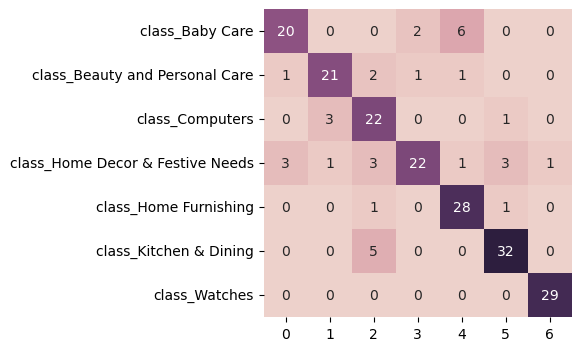

In [64]:
# Créer la matrice de confusion
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Créer le dataframe de confusion
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])

# Configuration de la figure
plt.figure(figsize = (6,4))

# Visualisation de la matrice de confusion
sns.heatmap(df_cm, square=True, annot=True, annot_kws={"size": 10}, fmt='.0f', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)

La matrice de confusion confirme les bons scores. Toutefois, la classe Kitchen & dining est encore trop souvent prédite avec cette approche.

_**Prédictions sur le datast de test**_

In [65]:
predictions4 = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model4.predict(images)
    predictions4 += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions4)

1/1 [==============================] - 4s 4s/step
[4, 4, 0, 4, 0, 3, 4, 1, 5, 0, 2, 2, 6, 5, 3, 0, 4, 3, 0, 2, 6, 0, 1, 5, 2, 1, 3, 0, 1, 4, 4, 5, 6, 5, 1, 1, 0, 1, 2, 2, 6, 6, 1, 2, 6, 2, 3, 2, 4, 4, 5, 3, 6, 1, 1, 4, 6, 0, 3, 1, 1, 3, 0, 5, 6, 4, 5, 3, 4, 6, 6, 6, 3, 5, 2, 1, 5, 5, 5, 1, 2, 4, 6, 1, 4, 6, 2, 4, 3, 3, 0, 0, 3, 4, 6, 2, 0, 0, 0, 1, 6, 4, 2, 5, 0, 4, 5, 2, 5, 3, 0, 6, 6, 3, 2, 3, 2, 6, 3, 1, 0, 5, 2, 3, 1, 6, 4, 3, 4, 2, 6, 5, 5, 3, 4, 1, 4, 0, 4, 6, 2, 1, 3, 1, 4, 2, 0, 5, 5, 0, 4, 2, 4, 5, 2, 0, 2, 4, 6, 5, 3, 1, 3, 0, 0, 1, 5, 0, 5, 2, 3, 3, 6, 3, 1, 1, 0, 2, 0, 2, 5, 1, 2, 5, 3, 1, 5, 2, 3, 0, 4, 6, 6, 0, 5, 2, 1, 0, 6, 3, 5, 6, 4, 6, 1, 6, 3, 1, 5, 4]

[4, 4, 0, 4, 0, 3, 4, 1, 5, 0, 2, 2, 6, 5, 3, 0, 4, 5, 2, 2, 6, 0, 1, 5, 2, 1, 3, 0, 1, 4, 4, 5, 6, 5, 1, 1, 1, 1, 2, 2, 6, 6, 1, 2, 6, 1, 3, 2, 2, 4, 5, 1, 6, 2, 1, 4, 6, 0, 3, 1, 2, 3, 0, 1, 5, 4, 5, 3, 4, 6, 6, 6, 2, 5, 2, 2, 5, 5, 0, 1, 2, 4, 6, 1, 4, 6, 2, 4, 3, 3, 0, 0, 3, 4, 6, 2, 0, 0, 0, 1, 6, 4, 2, 1, 0, 4,

In [66]:
score4_r2 = model4.evaluate(dataset_test)[1]
print("r2 : ",score4_r2)

7/7 [==============================] - 45s 6s/step - loss: 0.6079 - accuracy: 0.8333
r2 :  0.8333333134651184


In [67]:
score4_ari = metrics.adjusted_rand_score(labels_test, predictions4)
print("ARI : ", score4_ari)

ARI :  0.6513507170629912


### <font color = "#ef4155"> <a id="8"></a> **4. Comparaison des résultats**

In [68]:
resultats = pd.DataFrame(index = ['modele_de_reference', 'ImageDataGenerator', 'Approche_nouvelle','Appr_nouv_avec_data_augmentation'],
                         columns = ['score_train_set', 'score_val_set', 'score_test_set', 'ARI', 'temps_entrainement(s)'])

In [69]:
resultats['score_train_set'] = [accuracy1_train, accuracy2_train, accuracy3_train, accuracy4_train]
resultats['score_val_set'] = [accuracy1_val, accuracy2_val, accuracy3_val, accuracy4_val]
resultats['score_test_set'] = [test_acc1, score2_r2, score3_r2, score4_r2]
resultats['ARI'] = [score1_ari, score2_ari, score3_ari, score4_ari]
resultats['temps_entrainement(s)'] = [duration1, duration2, duration3, duration4]
resultats

,score_train_set,score_val_set,score_test_set,ARI,temps_entrainement(s)
modele_de_reference,1.000000,0.823810,0.838095,0.661426,3008.440295
ImageDataGenerator,0.987302,0.804762,0.823810,0.638967,4722.553943
Approche_nouvelle,1.000000,0.828571,0.814286,0.627146,4392.116845
Appr_nouv_avec_data_augmentation,0.933333,0.828571,0.833333,0.651351,7121.254651


Les approches sans data augmentation ont un score de 100% sur le train_set. Elles sont en overfitting.

De plus, les approches avec data augmentation ont un meilleur score sur le test_set et sur l'ARI. En revanche, elles peuvent nécessiter un temps d'entraînement trop important comme avec le modèle "Approche nouvelle avec data augmentation".

Par conséquent, le meilleur modèle est "ImageDataGenerator". Avec ce modèle on obtient :
* Une précision de 82 % sur les données de test ;
* Un score ARI de 0.63 ;
* Et le temps d'entraînement le plus bas qu'avec le modèle "Approche nouvelle avec data augmentation", soit 78 minutes et 42 secondes.

### <font color = "#ef4155"> **Conclusion**

La classification automatique des produits en catégories à partir des données visuelles est précise à 82 %. Cette précision n'est pas suffisamment élevée et rejoint la conclusion faite lors de l'étude de faisabilité.

Pour éviter les erreurs, il serait intéressant :
* D'envisager une classification semi-automatique ;
* Ou d'améliorer la qualité des photographies (prendre de meilleur photo);